In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [8]:
# Reflect an existing database into a new model

# Declare a Base
Base = automap_base()

# Use the Base to reflect the database tables
Base.prepare(engine, reflect = True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement_table = Base.classes.measurement

station_table = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Get the Latest date in the table
lastDate = session.query(measurement_table.date).order_by(measurement_table.date.desc()).first()
lastDate

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Hold session query in a variable for easier reading
lastYear = session.query(measurement_table.date, measurement_table.prcp).\
                filter(measurement_table.date >= (dt.date(2017, 8, 23) - dt.timedelta(weeks = 52))).\
                order_by(measurement_table.date).all()

# Variable to hold current date and total precipitation in the loop
currentDate = ""
totalPrecipitation = 0
count = 0

# Lists to hold the values for date and precipation
date = []
precipitation = []

# Perform a query to retrieve the data and precipitation scores
for row in lastYear:
    # Initialize the currentDate variable as the first isntance of row
    if currentDate == "":
        currentDate = row[0]
    
    # Check if the current row has the same date; if so, add the prcp value to totalPrecipitation
    if currentDate == row[0]:
        # Ignore None values for addition
        if row[1] is not None:
            totalPrecipitation = round(totalPrecipitation + float(row[1]),2)
        count += 1
    # Check if the current row has a new date; if so, add values to lists and reset values for the loop
    else:
        # Add the currentDate and avg precipation to their respective lists
        date.append(currentDate)
        precipitation.append(totalPrecipitation / count)
        # Update the current date and reset totalPrecipiation and count
        currentDate = row[0]
        totalPrecipitation = 0
        count = 0
        
# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(
        { 
            "Date" : date,
            "Precipitation" : precipitation
        })

# Set the Index to date column
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()

,Precipitation
Date,
2016-08-24,1.332857
2016-08-25,0.076667
2016-08-26,0.020000
2016-08-27,0.064000
2016-08-28,0.618000


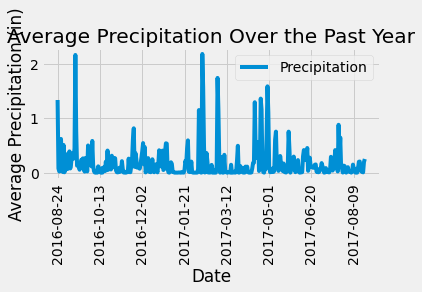

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(rot = 90)

#Format the Plot
ax.set_title("Average Precipitation Over the Past Year")
ax.set_ylabel("Average Precipitation (in)")
ax.set_xlabel("Date")
plt.tight_layout()

#Save the graph to Images Folder
ax.figure.savefig("../Images/precipitation_graph.pdf", dpi = 400)

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,364.000000
mean,0.176564
std,0.299752
min,0.000000
25%,0.010000
50%,0.076667
75%,0.205000
max,2.178000


In [41]:
# Design a query to show how many stations are available in this dataset?
totalStation = session.query(station_table.station).count()
totalStation

9

In [45]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement_table.station, func.count(measurement_table.station)).\
        group_by(measurement_table.station).\
        order_by(func.count(measurement_table.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
minTemp = session.query(func.min(measurement_table.tobs)).\
        filter(measurement_table.station == "USC00519281").all()

avgTemp = session.query(func.avg(measurement_table.tobs)).\
        filter(measurement_table.station == "USC00519281").all()

maxTemp = session.query(func.max(measurement_table.tobs)).\
        filter(measurement_table.station == "USC00519281").all()

print(f"Lowest Temperature: {minTemp}\nAverage Temperature: {avgTemp}\nHighest Temperature: {maxTemp}")

Lowest Temperature: [(54.0,)]
Average Temperature: [(71.66378066378067,)]
Highest Temperature: [(85.0,)]


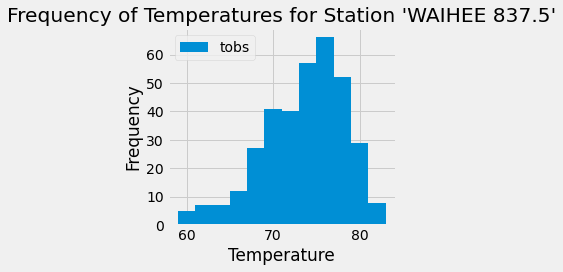

In [54]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram 
topStation_data = session.query(measurement_table.date, measurement_table.tobs).\
                filter(measurement_table.date >= (dt.date(2017, 8, 23) - dt.timedelta(weeks = 52))).\
                filter(measurement_table.station == "USC00519281").all()

# Convert the query to a dataframe
topStation_df = pd.DataFrame(topStation_data)

# Plot the Histogram
ax = topStation_df.plot(kind = "hist", bins = 12)

# Format the Histogram
ax.set_title("Frequency of Temperatures for Station 'WAIHEE 837.5'")
ax.set_ylabel("Frequency")
ax.set_xlabel("Temperature")
plt.tight_layout()

# Save the Histogram as a file in 'Images'
ax.figure.savefig("../Images/station_Waihee837_Temps.pdf", dpi = 400)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
